<a href="https://colab.research.google.com/github/Colossus08/ML-Assignment-2/blob/main/ML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

In [ ]:
!unzip /content/Image_classification_data.zip

Lorem Ipsum

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [5]:
df=pd.read_csv('/content/data_labels_mainData.csv')

In [6]:
df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [7]:
df.columns

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')

In [8]:
df.value_counts('cellTypeName')

,count
cellTypeName,
epithelial,4079
inflammatory,2543
fibroblast,1888
others,1386


In [9]:
len(df.value_counts('patientID'))

60

In [10]:
df.value_counts('cellType')

,count
cellType,
2,4079
1,2543
0,1888
3,1386


In [23]:
from sklearn.model_selection import train_test_split
train_df,val_df=train_test_split(df[['ImageName','cellTypeName']],test_size=0.2,stratify=df['cellType'],random_state=42)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


training_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')
validation_datagen=ImageDataGenerator(rescale=1./255,data_format='channels_last')

In [25]:
batch_size=32

In [39]:
training_generator=training_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='sparse'
)


validation_generator=validation_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/content/patch_images/',
    x_col='ImageName',
    y_col='cellTypeName',
    target_size=(27,27),
    batch_size=batch_size,
    class_mode='sparse'
)

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [40]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27,27,3)),
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0],-1,name=None)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [41]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

In [42]:
history=model.fit(training_generator,epochs=30,validation_data=validation_generator)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.4710 - val_loss: 0.9225 - val_sparse_categorical_accuracy: 0.6616
Epoch 2/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.9317 - sparse_categorical_accuracy: 0.6525 - val_loss: 0.7844 - val_sparse_categorical_accuracy: 0.7152
Epoch 3/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.8307 - sparse_categorical_accuracy: 0.7017 - val_loss: 0.7887 - val_sparse_categorical_accuracy: 0.6955
Epoch 4/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.8356 - sparse_categorical_accuracy: 0.6823 - val_loss: 0.7812 - val_sparse_categorical_accuracy: 0.6828
Epoch 5/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.8027 - sparse_categorical_accuracy: 0.6982 - val_loss: 0.7421 - val_sparse_categorical_accuracy: 0.7152
Epoch 6/30
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.7968 - sparse_categorical_accuracy: 0.7068 - val_loss: 0.7216 - val_sparse_categorical_accuracy: 0.7338
Epoch 7/3

In [43]:
import matplotlib.pyplot as plt

In [44]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

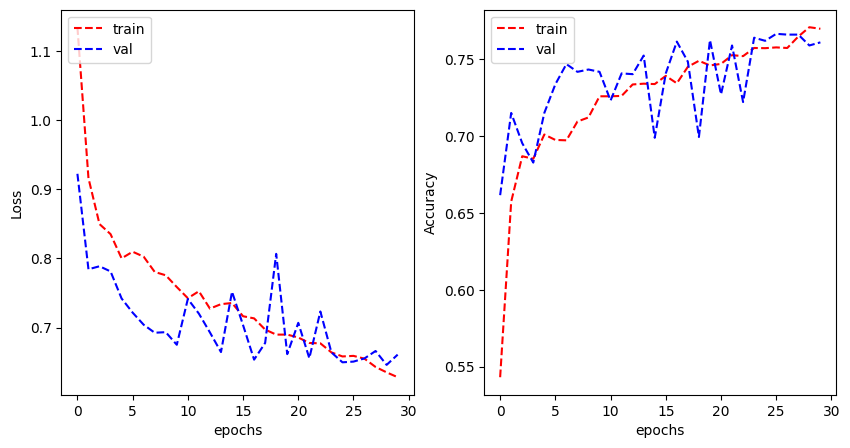

In [45]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'r--')
plt.plot(history.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['sparse_categorical_accuracy'], 'r--')
plt.plot(history.history['val_sparse_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()